# DATA 607 Final Project: Garbage Classification

## Ibtassam Rasheed (30201479), Imad Ahmad (30198988), Jose Palacios (30190988), Onur Taylan Cicek (30184538)

## Packages

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Input, Dropout
from keras.optimizers import Adam
from keras.metrics import Accuracy
from keras.models import load_model
from keras.utils import np_utils

from matplotlib import pyplot as plt

import shutil
import os
import imghdr
import numpy as np
import pandas as pd
import cv2
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Table of Contents

* [Introduction](#zero-bullet)
* [Data Collection & Processing](#first-bullet)
* [Classification Models](#second-bullet)
* [Model Comparison](#third-bullet)
* [Conclusion](#fourth-bullet)
* [References](#fifth-bullet)


# **1. Introduction** <a class="anchor" id="zero-bullet"></a>

The world today faces an unprecedented waste management crisis, exacerbated by rapid urbanization 

and population growth (Hoornweg et al., 2015). Efficient waste management is essential not only to aid the environmental impacts of waste disposal, but also to promote a sustainable economy (Kaza et al., 2018). One of the most pressing challenges in waste management is the accurate and efficient classification of waste (Silva et al., 2020). This is particularly important for recycling, as correct classification and separation of waste are prerequisites for high-quality recycling processes.  

Recent advancements in computer vision and machine learning have opened new possibilities for automating the process of waste classification, reducing human error and streamlining recycling operations. These technologies, when applied effectively, can greatly improve waste management systems and contribute to a more sustainable future.  

This project aims to develop a trash classification model that utilizes deep learning techniques to accurately classify images of waste into distinct categories. The specific categories we will be classifying into a "recycling", "compost", and "trash". Leveraging state-of-the-art algorithms, these models seek to optimize classification performance, ensuring a better waste sorting process. By addressing the critical issue of waste classification, this project contributes to the broader goal of improving waste management systems and promoting environmental sustainability. 

Our main research questions are: 
 

1. Which classifier produces the strongest results for classifying the images? 

2. Can we build a classifier that is accurate enough that it can be used in a practical setting without causing more harm than good? 

# **2. Data Collection & Processing** <a class="anchor" id="first-bullet"></a>

The main portion of the data was pulled from Kaggle (Mohamed, 2021), and is available to us through the open data commons license (ODbL). This data was classified with twelve different labels, featuring 15,000 images of waste. We did our best to reduce these into three classes, removing data where necessary.  

In [ ]:
os.environ['KAGGLE_USERNAME'] = '---' # kaggle API username
os.environ['KAGGLE_KEY'] = '---' # kaggle API key
! kaggle datasets download -d mostafaabla/garbage-classification

garbage-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
file_name = "/content/garbage-classification.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [ ]:
import shutil
dir = "/content/garbage_classification/"
trash_list = ['trash', 'clothes', 'battery', 'shoes']
recyc_list = ['plastic', 'brown-glass', 'white-glass', 'cardboard', 'green-glass', 'metal', 'paper']
comp_list = ['biological']
for folder in os.listdir(dir):
  if folder in trash_list:
    dir_path = dir + 'trash/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)
  elif folder in recyc_list:
    dir_path = dir + 'recyc/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)
  elif folder in comp_list:
    dir_path = dir + 'comp/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)

for folder in os.listdir(dir):
  if folder not in ['trash', 'recyc', 'comp']:
    os.rmdir(dir + folder)

In [ ]:
num_classes = len(list(os.listdir(dir)))
print(f'There are {num_classes} classes to classify')

There are 3 classes to classify


## Reading Images

In [ ]:
images = []
labels = []
for img, label in tf.keras.utils.image_dataset_from_directory(directory='/content/garbage_classification', 
                                                              labels='inferred',
                                                              label_mode = 'int',
                                                              batch_size=None,
                                                              image_size=(16, 16)).take(-1).as_numpy_iterator():
  images.append(img)
  labels.append(label)

Found 15515 files belonging to 3 classes.


## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

#Scaling RGB values to [0,1] range 
images = np.array(images)
images = images / 255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, train_size = 0.8, random_state = 156, stratify= labels)

height, width, channels = (images.shape[1],images.shape[2],images.shape[3])

x_flat_train = x_train.reshape(x_train.shape[0], height * width * channels) 
x_flat_test = x_test.reshape(x_test.shape[0], height * width * channels)

del images, labels

In [ ]:
import pickle
with open('x_train.pkl', 'wb') as file:
    pickle.dump(x_train, file)

with open('x_test.pkl', 'wb') as file:
    pickle.dump(x_test, file)

with open('y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)

with open('y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

with open('x_flat_train.pkl', 'wb') as file:
    pickle.dump(x_flat_train, file)

with open('x_flat_test.pkl', 'wb') as file:
    pickle.dump(x_flat_test, file)

from google.colab import files
files.download('x_train.pkl')
files.download('x_test.pkl')
files.download('y_train.pkl')
files.download('y_test.pkl')
files.download('x_flat_train.pkl')
files.download('x_flat_test.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Checking for Class Distributions

In [ ]:
import plotly.express as px
import pandas as pd

train_counts = pd.Series(y_train).value_counts(normalize = True)
test_counts = pd.Series(y_test).value_counts(normalize = True)

counts_df = pd.DataFrame({
    'Category': ['Trash', 'Recyclable', 'Compostable'],
    'Train': train_counts,
    'Test': test_counts
})

melted_df = pd.melt(counts_df, id_vars=['Category'], var_name='Dataset', value_name='Count')

fig = px.bar(melted_df, 
             x='Category', 
             y='Count', 
             color='Dataset',
             barmode='group',
             template = 'simple_white',
             color_discrete_sequence = ['crimson', 'gray'],
             title = '<b>Comparing Class Distributions in Train and Datasets<b><br><sub>With the help of stratification, both train and test datasets are identical in terms of proportional allocation<sub>')
fig.show()

In light of the bar plot provided, we can justify the class imbalances in our train and test datasets, where trash > recyc > comp, by stating that these proportions are in line with real-world data observed in different countries and cities. Studies conducted in Lahore, Pakistan (Nazeer et al., 2019), Bangalore, India (Kulkarni & Anantharama, 2020), and Istanbul, Turkey (Ozkan et al., 2017) all indicate varying percentages of trash, recycling, and composting depending on factors such as local waste management practices, infrastructure, and cultural norms.

By maintaining these imbalances, our dataset reflects the actual distribution of waste found across various locations, which will help our model generalize better and make more accurate predictions when applied to real-world scenarios. If we were to use oversampling or undersampling techniques to artificially balance the classes, we would risk introducing biases that could potentially hinder the model's ability to perform well in diverse situations.








# **3. Classification Models** <a class="anchor" id="second-bullet"></a>

In [ ]:
models_df = pd.DataFrame(columns = ['Model', 'Test_Accuracy', 'F1_Score'])

### Support Vector Machine (SVM)

Support Vector Machines (SVM) is a supervised machine learning algorithm utilized for classification and regression tasks. SVM operates by constructing an optimal hyperplane or decision boundary that separates data points into different classes while maximizing the margin between these classes. It achieves this by identifying support vectors, which are the data points that lie closest to the decision boundary, and computing the optimal hyperplane based on these support vectors. The algorithm is particularly effective in high-dimensional spaces and is capable of handling linear and nonlinear classification problems (Cortes & Vapnik, 1995). 

The hyperparameter C is a regularization parameter that controls the trade-off between maximizing the margin and minimizing the classification error (Cortes & Vapnik, 1995). A smaller value of C creates a wider margin but allows for more misclassifications, while a larger value of C results in a narrower margin with fewer misclassifications. The kernel function is another crucial hyperparameter, responsible for transforming the input data into a higher-dimensional space to enable nonlinear classification. Common kernel functions include linear, polynomial, radial basis function (RBF), and sigmoid kernels. The choice of kernel function and its associated parameters can significantly impact the performance of the SVM model (Schölkopf et al., 1997). These were the hyperparameters we tuned for this model. 

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

params = {'C': [1, 5], #Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
          'kernel': ['rbf', 'poly']} #Specifies the kernel type to be used in the algorithm. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).


svm = SVC()
grid_search = GridSearchCV(estimator = svm, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(x_flat_train, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ....................................C=1, kernel=rbf; total time=  37.9s
[CV] END ....................................C=1, kernel=rbf; total time=  54.2s
[CV] END ....................................C=1, kernel=rbf; total time=  37.0s
[CV] END ....................................C=1, kernel=rbf; total time=  35.9s
[CV] END ....................................C=1, kernel=rbf; total time=  34.8s
[CV] END ...................................C=1, kernel=poly; total time= 1.1min
[CV] END ...................................C=1, kernel=poly; total time= 1.1min
[CV] END ...................................C=1, kernel=poly; total time= 1.1min
[CV] END ...................................C=1, kernel=poly; total time= 1.0min
[CV] END ...................................C=1, kernel=poly; total time= 1.2min
[CV] END ....................................C=5, kernel=rbf; total time=  43.3s
[CV] END ....................................C=5,

In [ ]:
best_svm = grid_search.best_estimator_

In [ ]:
y_pred = best_svm.predict(x_flat_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

Accuracy on Testing Set:  0.822429906542056


In [ ]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 Score on Testing Set: ", f1score)

F1 Score on Testing Set:  0.8195571891895203


In [ ]:
models_df = models_df.append(pd.Series(['SVM', accuracy, f1score], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)
models_df

,Model,Test_Accuracy,F1_Score
0,SVM,0.82243,0.819557


In [ ]:
with open('SVM_Model.pkl', 'wb') as file:
    pickle.dump(best_svm, file)

from google.colab import files
files.download('SVM_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### K-Nearest Neighbour (KNN) Classification

K-Nearest Neighbors (KNN) is a non-parametric, instance-based supervised learning algorithm used for classification and regression tasks. KNN works by identifying the k nearest data points in the feature space to a given query point and determining the class or output value based on the majority vote or average of these neighboring instances. The algorithm is lazy, meaning it does not build an explicit model but instead stores the entire training dataset and performs calculations during the prediction phase, making it computationally efficient during training (Cover & Hart, 1967). 

The number of neighbors (k) is a critical hyperparameter in KNN, which determines the number of nearest data points considered for prediction. A smaller k value may result in overfitting due to high sensitivity to noise, while a larger k value can lead to underfitting and decreased accuracy (Hastie, Tibshirani, & Friedman, 2009). The weights parameter, which can be either uniform or distance-based, is used to assign importance to the neighbors. Uniform weighting treats all neighbors equally, while distance-based weighting assigns higher importance to closer neighbors (Hechenbichler & Schliep, 2004). The distance metric, such as Euclidean or Manhattan, is another key hyperparameter that defines how the distance between data points is measured. Different distance metrics can influence the performance of KNN depending on the dataset's characteristics and the problem's nature (Cha, 2007). 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors': [5, 7], #Number of neighbors to use by default for kneighbors queries.
          'weights': ['uniform', 'distance'], #‘uniform’ : uniform weights. All points in each neighborhood are weighted equally. ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
          'p': [1, 2]} #Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator = knn, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(x_flat_train, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=  20.9s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=  17.5s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=  16.3s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=  16.3s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=  17.1s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=  16.5s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=  16.8s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=  16.6s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=  16.6s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=  17.0s
[CV] END ................n_neighbors=5, p=2, weights=uniform; total time=   1.0s
[CV] END ................n_neighbors=5, p=2, weig

In [ ]:
best_knn = grid_search.best_estimator_

In [ ]:
y_pred = best_knn.predict(x_flat_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

Accuracy on Testing Set:  0.7686110215920078


In [ ]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 Score on Testing Set: ", f1score)

F1 Score on Testing Set:  0.7537571894531799


In [ ]:
models_df = models_df.append(pd.Series(['KNN', accuracy, f1score], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)
models_df

,Model,Test_Accuracy,F1_Score
0,SVM,0.822430,0.819557
1,KNN,0.768611,0.753757


In [ ]:
import pickle
with open('KNN_Model.pkl', 'wb') as file:
    pickle.dump(best_knn, file)

from google.colab import files
files.download('KNN_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Gauissian Naive Bayes (GNB) Classifier

Gaussian Naive Bayes (GNB) is a probabilistic supervised learning algorithm based on the Bayes theorem with an assumption of conditional independence among features (Murphy, 2006). This algorithm is particularly effective for classification tasks, especially when dealing with continuous data. GNB estimates the class-conditional probability distributions of the features, assuming each feature follows a Gaussian distribution. Despite its simplicity and the naive assumption, GNB often performs surprisingly well in practice, especially in cases where the features are conditionally independent or weakly correlated (Rish, 2001). 

A critical hyperparameter in Gaussian Naive Bayes is the variance smoothing parameter, which is used to mitigate the impact of zero probabilities and improve model stability. By adding a small positive value to the variance estimates, the algorithm ensures that all features contribute to the class-conditional probabilities, thus preventing the model from being overly influenced by rare or unseen feature values. The choice of the variance smoothing parameter can significantly affect the performance of the Gaussian Naive Bayes model, with a smaller value leading to a more sensitive model and a larger value providing more smoothing and robustness (Manning & Schütze, 1999). 

In [ ]:
from sklearn.naive_bayes import GaussianNB

params = {'var_smoothing': np.linspace(0,0.5, num=50)}
gnb = GaussianNB()

grid_search = GridSearchCV(estimator = gnb, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(x_flat_train, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..................................var_smoothing=0.0; total time=   0.1s
[CV] END ..................................var_smoothing=0.0; total time=   0.1s
[CV] END ..................................var_smoothing=0.0; total time=   0.1s
[CV] END ..................................var_smoothing=0.0; total time=   0.1s
[CV] END ..................................var_smoothing=0.0; total time=   0.1s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.1s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.1s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.1s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.1s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.1s
[CV] END ..................var_smoothing=0.02040816326530612; total time=   0.1s
[CV] END ..................var_smoothing=0.0204

In [ ]:
best_gnb = grid_search.best_estimator_

In [ ]:
y_pred = best_gnb.predict(x_flat_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

Accuracy on Testing Set:  0.5336770866902997


In [ ]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 Score on Testing Set: ", f1score)

F1 Score on Testing Set:  0.5527296584470879


In [ ]:
models_df = models_df.append(pd.Series(['GNB', accuracy, f1score], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)
models_df

,Model,Test_Accuracy,F1_Score
0,SVM,0.822430,0.819557
1,KNN,0.768611,0.753757
2,GNB,0.533677,0.552730


In [ ]:
import pickle
with open('GNB_Model.pkl', 'wb') as file:
    pickle.dump(best_gnb, file)

from google.colab import files
files.download('GNB_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Random Forest (RFC) Classifier

Random Forests is an ensemble learning method used for both classification and regression tasks, which constructs multiple decision trees during training and combines their outputs to generate predictions. By averaging the predictions from multiple trees, Random Forests mitigates the overfitting problem often observed in individual decision trees, resulting in improved generalization and more robust performance. The algorithm's inherent ability to capture feature interactions and handle missing data makes it a popular choice for various applications (Breiman, 2001). 

Two important hyperparameters in Random Forests are the number of trees and the maximum depth of the trees. The number of trees (n_estimators) directly affects the ensemble's performance and stability, with a larger number of trees generally leading to more accurate predictions and lower variance (Breiman, 2001). However, increasing the number of trees also results in higher computational cost and diminishing returns in terms of accuracy improvement. The maximum depth (max_depth) controls the depth of each tree in the ensemble, which in turn influences the model's complexity and generalization capability (Geurts, Ernst, & Wehenkel, 2006). A smaller max_depth value may lead to underfitting, while a larger value increases the risk of overfitting. Fine-tuning both hyperparameters is crucial for achieving the best balance between model complexity and generalization. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators': [100, 200], #The number of trees in the forest.
          'max_depth': [5, 10]}, #The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

rfc = RandomForestClassifier(random_state=2019)

grid_search = GridSearchCV(estimator = rfc, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(x_flat_train, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ......................max_depth=5, n_estimators=100; total time=   9.4s
[CV] END ......................max_depth=5, n_estimators=100; total time=   9.3s
[CV] END ......................max_depth=5, n_estimators=100; total time=   9.6s
[CV] END ......................max_depth=5, n_estimators=100; total time=   8.8s
[CV] END ......................max_depth=5, n_estimators=100; total time=   9.5s
[CV] END ......................max_depth=5, n_estimators=200; total time=  18.0s
[CV] END ......................max_depth=5, n_estimators=200; total time=  18.8s
[CV] END ......................max_depth=5, n_estimators=200; total time=  17.8s
[CV] END ......................max_depth=5, n_estimators=200; total time=  18.5s
[CV] END ......................max_depth=5, n_estimators=200; total time=  17.8s
[CV] END .....................max_depth=10, n_estimators=100; total time=  16.7s
[CV] END .....................max_depth=10, n_est

In [ ]:
best_rfc = grid_search.best_estimator_

In [ ]:
y_pred = best_rfc.predict(x_flat_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

Accuracy on Testing Set:  0.7831131163390267


In [ ]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 Score on Testing Set: ", f1score)

F1 Score on Testing Set:  0.7620035679870039


In [ ]:
models_df = models_df.append(pd.Series(['RFC', accuracy, f1score], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)
models_df

,Model,Test_Accuracy,F1_Score
0,SVM,0.822430,0.819557
3,RFC,0.783113,0.762004
1,KNN,0.768611,0.753757
2,GNB,0.533677,0.552730


In [ ]:
import pickle
with open('RFC_Model.pkl', 'wb') as file:
    pickle.dump(best_rfc, file)

from google.colab import files
files.download('RFC_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### XGBoost (XGB) Classifier

XGBoost (eXtreme Gradient Boosting) is a scalable and efficient implementation of the gradient boosted trees algorithm, used for classification, regression, and ranking tasks (Chen & Guestrin, 2016). XGBoost combines the strengths of both tree-based algorithms and boosting techniques, leading to high predictive accuracy and robustness. The algorithm sequentially builds decision trees by optimizing an objective function that includes a differentiable loss function and a regularization term, which prevents overfitting. XGBoost is particularly well-suited for large-scale datasets, as it employs parallel and distributed computing techniques to accelerate the training process. 

In [ ]:
from xgboost import XGBClassifier

params = {'n_estimators': [100, 200],
          'max_depth': [5, 10],
          'learning_rate': [0.1, 0.01, 0.001]}

xgb = XGBClassifier(random_state=2019, tree_method = 'gpu_hist')

grid_search = GridSearchCV(estimator = xgb, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(x_flat_train, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   5.0s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   4.6s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   4.5s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   4.5s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   5.0s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   8.3s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   8.8s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   8.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   7.8s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   8.8s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=  28.2s
[CV] END ..learning_rate=0.1, max_depth=10, n_es

In [ ]:
best_xgb = grid_search.best_estimator_

In [ ]:
y_pred = best_xgb.predict(x_flat_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

Accuracy on Testing Set:  0.8266194005800838


In [ ]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 Score on Testing Set: ", f1score)

F1 Score on Testing Set:  0.8186371900028467


In [ ]:
models_df = models_df.append(pd.Series(['XGB', accuracy, f1score], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)
models_df

,Model,Test_Accuracy,F1_Score
4,XGB,0.826619,0.818637
0,SVM,0.822430,0.819557
3,RFC,0.783113,0.762004
1,KNN,0.768611,0.753757
2,GNB,0.533677,0.552730


In [ ]:
import pickle
with open('XGB_Model.pkl', 'wb') as file:
    pickle.dump(best_xgb, file)

from google.colab import files
files.download('XGB_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convolutional Neural Network (CNN) Classifier

Convolutional Neural Networks (CNNs) are a type of neural network that has taken a defining role in world of computer vision. Their strength is in image classification and object recognition tasks, as they can extract relevant features from the data. CNNs are composed of multiple layers, which learn to identify and highlight patterns in the input image. These layers (or filters) are designed to capture local spatial relationships between pixels or elements in the input, enabling the network to identify complex structures and patterns in the data. To make the network more robust to changes in the input, CNNs often include pooling layers. These layers reduce the dimensionality of the feature maps, making the network more resistant to translation and rotation of the input. By using multiple convolutional and pooling layers, CNNs can learn increasingly abstract and complex features from the input, and ultimately make accurate predictions on the test data. The other strength of CNN is the support for GPU usage. Since CNNs are computationally expensive with large datasets, this support comes in handy. One other drawback of CNN is that they are not interpretable. 

The process of optimizing the hyperparameters of a Convolutional Neural Network can be rather involved, as it necessitates a careful balancing of various parameters like layer count, filter dimensions, and pooling methodology. Tweaking these characteristics can exert a significant impact on the model's effectiveness, so a patient approach is required to find the optimal balance between complexity and overfitting. To do this, one must employ search techniques that are systematic and comprehensive, such as those involving random sampling or gridded search algorithms. 

In [ ]:
np.random.seed(1337) 
inputs = Input(shape=(height, width, channels))

m = Conv2D(32, (3, 3), activation='relu')(inputs)
m = Conv2D(32, (3, 3), activation='relu')(m) 
m = MaxPooling2D(2, 2)(m)
m = Conv2D(64, (3, 3), activation='relu')(m)
m = Conv2D(64, (3, 3), activation='relu')(m)
m = MaxPooling2D(2, 2)(m)
m = Flatten()(m)
m = Dense(128, activation='relu')(m)
m = Dense(128, activation='relu')(m)
fm = Dense(num_classes, activation='softmax')(m)

sub_model = Model(inputs=inputs, outputs=m)
cnn_model = Model(inputs=inputs, outputs=fm)

In [ ]:
adam = Adam(lr=1e-4)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

cnn_model.compile(optimizer=adam,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

hist = cnn_model.fit(x_train, 
                     y_train, 
                     epochs=20, 
                     validation_split=0.2,
                     batch_size=64)

loss, accuracy = cnn_model.evaluate(x_test, 
                                    y_test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

Epoch 1/20
156/156 [==============================] - 2s 8ms/step - loss: 0.4647 - accuracy: 0.7986 - val_loss: 0.5175 - val_accuracy: 0.7684
Epoch 2/20
156/156 [==============================] - 1s 8ms/step - loss: 0.4611 - accuracy: 0.7959 - val_loss: 0.4945 - val_accuracy: 0.7918
Epoch 3/20
156/156 [==============================] - 1s 5ms/step - loss: 0.4579 - accuracy: 0.7997 - val_loss: 0.5120 - val_accuracy: 0.7853
Epoch 4/20
156/156 [==============================] - 1s 5ms/step - loss: 0.4562 - accuracy: 0.8031 - val_loss: 0.5362 - val_accuracy: 0.7624
Epoch 5/20
156/156 [==============================] - 1s 5ms/step - loss: 0.4543 - accuracy: 0.8047 - val_loss: 0.4858 - val_accuracy: 0.7894
Epoch 6/20
156/156 [==============================] - 1s 5ms/step - loss: 0.4439 - accuracy: 0.8087 - val_loss: 0.4802 - val_accuracy: 0.7950
Epoch 7/20
156/156 [==============================] - 1s 6ms/step - loss: 0.4357 - accuracy: 0.8141 - val_loss: 0.4770 - val_accuracy: 0.8059
Epoch 

In [ ]:
y_pred = cnn_model.predict(x_test)
y_pred = y_pred.argmax(axis=-1)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

97/97 [==============================] - 0s 4ms/step
Accuracy on Testing Set:  0.7924589107315501


In [ ]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 Score on Testing Set: ", f1score)

F1 Score on Testing Set:  0.7887599315496701


In [ ]:
models_df = models_df.append(pd.Series(['CNN', accuracy, f1score], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)
models_df

,Model,Test_Accuracy,F1_Score
0,XGB,0.826619,0.818637
1,SVM,0.822430,0.819557
5,CNN,0.792459,0.788760
2,RFC,0.783113,0.762004
3,KNN,0.768611,0.753757
4,GNB,0.533677,0.552730


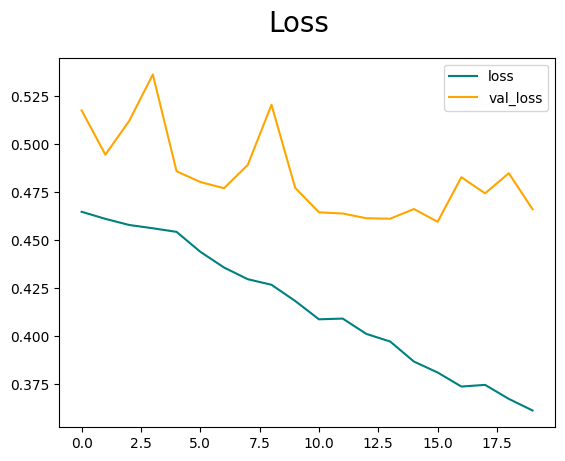

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

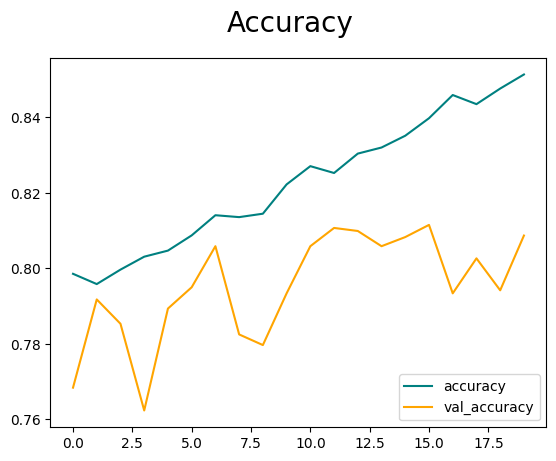

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

In [ ]:
sub_model.save('/content/CNN_FinalDenseLayer.h5')
cnn_model.save('/content/CNN_Model.h5')

from google.colab import files
files.download('CNN_Model.h5')
files.download('CNN_FinalDenseLayer.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_file = sub_model.predict(x_train)
test_file = sub_model.predict(x_test)

z = np.concatenate([np.array(train_file).reshape(train_file.shape[0],train_file.shape[1]),np.array(y_train).reshape(train_file.shape[0],1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('train_file.csv',index=False)

z = np.concatenate([np.array(test_file).reshape(test_file.shape[0],test_file.shape[1]),np.array(y_test).reshape(test_file.shape[0],1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('test_file.csv',index=False)

97/97 [==============================] - 0s 2ms/step


In [ ]:
files.download('train_file.csv')
files.download('test_file.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convolutional SVM

Convolutional Neural Networks when used with Support Vector Machines (CNN-SVM) are a type of hybrid ML model. Their strength is the ability to extract meaningful features from data using the convolutional layers of the CNN and then they use SVM to make accurate predictions. The CNN-SVM model consists of multiple convolutional layers and SVM classifiers. They can handle high-dimensional data but are computationally expensive when using complex architectures. They also require a large amount of labeled training data to achieve high performance.  

In [ ]:
params = {'C': [1, 5],
          'kernel': ['rbf', 'poly']}

svm = SVC()
grid_search = GridSearchCV(estimator = svm, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(train_file, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ....................................C=1, kernel=rbf; total time=   3.7s
[CV] END ....................................C=1, kernel=rbf; total time=   3.7s
[CV] END ....................................C=1, kernel=rbf; total time=   4.4s
[CV] END ....................................C=1, kernel=rbf; total time=   3.7s
[CV] END ....................................C=1, kernel=rbf; total time=   3.3s
[CV] END ...................................C=1, kernel=poly; total time=   3.8s
[CV] END ...................................C=1, kernel=poly; total time=   3.6s
[CV] END ...................................C=1, kernel=poly; total time=   3.2s
[CV] END ...................................C=1, kernel=poly; total time=   3.2s
[CV] END ...................................C=1, kernel=poly; total time=   3.5s
[CV] END ....................................C=5, kernel=rbf; total time=   3.7s
[CV] END ....................................C=5,

In [ ]:
best_cnn_svm = grid_search.best_estimator_

In [ ]:
y_pred = best_cnn_svm.predict(test_file)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

Accuracy on Testing Set:  0.807927811795037


In [ ]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 Score on Testing Set: ", f1score)

F1 Score on Testing Set:  0.8077611707926395


In [ ]:
models_df = models_df.append(pd.Series(['Convolutional SVM', accuracy, f1score], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)
models_df

,Model,Test_Accuracy,F1_Score
0,XGB,0.826619,0.818637
1,SVM,0.822430,0.819557
6,Convolutional SVM,0.807928,0.807761
2,CNN,0.792459,0.788760
3,RFC,0.783113,0.762004
4,KNN,0.768611,0.753757
5,GNB,0.533677,0.552730


In [ ]:
import pickle
with open('CNN_SVM_Model.pkl', 'wb') as file:
    pickle.dump(best_cnn_svm, file)

from google.colab import files
files.download('CNN_SVM_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convolutional KNN

Convolutional Neural Networks in collaboration with K-nearest neighbor (CNN-KNN) produce a powerful machine learning model. This model extracts significant characteristics from data using the convolutional layers of CNNs and then utilizes KNN to make precise predictions based on their distance and similarity (creating the best matches for the target feature). The CNN-KNN structure comprises multiple convolutional layers and KNN classifiers, making it a sophisticated architecture. While it excels in processing high-dimensional data, the complexity of the structure may make it computationally demanding. Additionally, the CNN-KNN model necessitates a vast quantity of accurately labeled training data to achieve peak performance. Furthermore, the model may be sensitive to outliers and noise in the data and also to choice of distance metric used. 

In [ ]:
params = {'n_neighbors': [5, 7],
          'weights': ['uniform', 'distance'], 
          'p': [1, 2]}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator = knn, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(train_file, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   3.5s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   2.6s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   3.6s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   2.6s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   2.5s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   2.5s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   2.5s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   3.6s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   2.5s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   2.5s
[CV] END ................n_neighbors=5, p=2, weights=uniform; total time=   0.3s
[CV] END ................n_neighbors=5, p=2, weig

In [ ]:
best_cnn_knn = grid_search.best_estimator_

In [ ]:
y_pred = best_cnn_knn.predict(test_file)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

Accuracy on Testing Set:  0.8121173058330647


In [ ]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 Score on Testing Set: ", f1score)

F1 Score on Testing Set:  0.8116377621656146


In [ ]:
models_df = models_df.append(pd.Series(['Convolutional KNN', accuracy, f1score], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)
models_df

,Model,Test_Accuracy,F1_Score
0,XGB,0.826619,0.818637
1,SVM,0.822430,0.819557
7,Convolutional KNN,0.812117,0.811638
2,Convolutional SVM,0.807928,0.807761
3,CNN,0.792459,0.788760
4,RFC,0.783113,0.762004
5,KNN,0.768611,0.753757
6,GNB,0.533677,0.552730


In [ ]:
import pickle
with open('CNN_KNN_Model.pkl', 'wb') as file:
    pickle.dump(best_cnn_knn, file)

from google.colab import files
files.download('CNN_KNN_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convolutional GNB

When Convolutional Neural Networks team up with Gaussian Naive Bayes (CNN-GNB), they become a potent hybrid machine learning model. They can extract significant features from data by leveraging the power of convolutional layers in CNNs, and then using Gaussian Naive Bayes to make precise predictions. The CNN-GNB model is a sophisticated architecture, comprising of multiple convolutional layers and GNB classifiers. While they excel in processing high-dimensional data, they do tend to be computationally expensive when dealing with complex structures. Additionally, the CNN-GNB model requires a large volume of accurately labeled training data to attain optimal performance. One drawback that we noticed is the sensitivity to outliers and noise in the data. 

In [ ]:
params = {'var_smoothing': np.linspace(0,0.5, num=50)}

gnb = GaussianNB()

grid_search = GridSearchCV(estimator = gnb, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(train_file, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..................................var_smoothing=0.0; total time=   0.0s
[CV] END ..................................var_smoothing=0.0; total time=   0.0s
[CV] END ..................................var_smoothing=0.0; total time=   0.0s
[CV] END ..................................var_smoothing=0.0; total time=   0.0s
[CV] END ..................................var_smoothing=0.0; total time=   0.0s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.0s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.0s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.0s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.0s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.0s
[CV] END ..................var_smoothing=0.02040816326530612; total time=   0.0s
[CV] END ..................var_smoothing=0.0204

In [ ]:
best_cnn_gnb = grid_search.best_estimator_

In [ ]:
y_pred = best_cnn_gnb.predict(test_file)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

Accuracy on Testing Set:  0.7573316145665485


In [ ]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 Score on Testing Set: ", f1score)

F1 Score on Testing Set:  0.7680640413987556


In [ ]:
models_df = models_df.append(pd.Series(['Convolutional GNB', accuracy, f1score], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)
models_df

,Model,Test_Accuracy,F1_Score
0,XGB,0.826619,0.818637
1,SVM,0.822430,0.819557
2,Convolutional KNN,0.812117,0.811638
3,Convolutional SVM,0.807928,0.807761
4,CNN,0.792459,0.788760
5,RFC,0.783113,0.762004
6,KNN,0.768611,0.753757
8,Convolutional GNB,0.757332,0.768064
7,GNB,0.533677,0.552730


In [ ]:
import pickle
with open('CNN_GNB_Model.pkl', 'wb') as file:
    pickle.dump(best_cnn_gnb, file)

from google.colab import files
files.download('CNN_GNB_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convolutional RFC

CNN-RFC (Convolutional Neural Network - Random Forest Classifier) is another hybrid algorithm and in this case, it combines the power of convolutional neural networks (CNNs) and random forests. It combines the feature extraction power of CNNs with the decision-making power of random forests. ​ Although it is a powerful algorithm for image recognition tasks & high-dimensional data, where CNNs can extract relevant features from the image and random forests can classify them accurately but they are computationally expensive with large datasets and requires a lot of memory to train. They are also not interpretable. ​ 

In [ ]:
params = {'n_estimators': [100, 200],
          'max_depth': [5, 10]}

rfc = RandomForestClassifier(random_state=2019)

grid_search = GridSearchCV(estimator = rfc, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(train_file, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ......................max_depth=5, n_estimators=100; total time=   5.9s
[CV] END ......................max_depth=5, n_estimators=100; total time=   3.2s
[CV] END ......................max_depth=5, n_estimators=100; total time=   3.1s
[CV] END ......................max_depth=5, n_estimators=100; total time=   3.8s
[CV] END ......................max_depth=5, n_estimators=100; total time=   3.2s
[CV] END ......................max_depth=5, n_estimators=200; total time=   6.5s
[CV] END ......................max_depth=5, n_estimators=200; total time=   6.9s
[CV] END ......................max_depth=5, n_estimators=200; total time=   6.8s
[CV] END ......................max_depth=5, n_estimators=200; total time=   6.4s
[CV] END ......................max_depth=5, n_estimators=200; total time=   7.0s
[CV] END .....................max_depth=10, n_estimators=100; total time=   5.5s
[CV] END .....................max_depth=10, n_est

In [ ]:
best_cnn_rfc = grid_search.best_estimator_

In [ ]:
y_pred = best_cnn_rfc.predict(test_file)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

Accuracy on Testing Set:  0.8127618433773768


In [ ]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 Score on Testing Set: ", f1score)

F1 Score on Testing Set:  0.8125587322155026


In [ ]:
models_df = models_df.append(pd.Series(['Convolutional RFC', accuracy, f1score], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)
models_df

,Model,Test_Accuracy,F1_Score
0,XGB,0.826619,0.818637
1,SVM,0.822430,0.819557
9,Convolutional RFC,0.812762,0.812559
2,Convolutional KNN,0.812117,0.811638
3,Convolutional SVM,0.807928,0.807761
4,CNN,0.792459,0.788760
5,RFC,0.783113,0.762004
6,KNN,0.768611,0.753757
7,Convolutional GNB,0.757332,0.768064
8,GNB,0.533677,0.552730


In [ ]:
import pickle
with open('CNN_RFC_Model.pkl', 'wb') as file:
    pickle.dump(best_cnn_rfc, file)

from google.colab import files
files.download('CNN_RFC_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convolutional XGB

A hybrid machine learning algorithm that combines Convolutional Neural Networks (CNNs) for feature extraction with Extreme Gradient Boosting (XGB) for classification, making it a powerful approach for classification tasks, especially in image recognition.​ It can handle high-dimensional data. Also, it has high accuracy on complex classification tasks, and it learns from the errors of previous models.​ But like all the CNN hybrid models, they come at a high computational cost and has the need for large amounts of labeled data to train accurately. They are also prone to overfitting if the training data is not diverse enough.​ 

In [ ]:
params = {'n_estimators': [100, 200],
          'max_depth': [5, 10],
          'learning_rate': [0.1, 0.01, 0.001]}

xgb = XGBClassifier(random_state=2019, tree_method = 'gpu_hist')

grid_search = GridSearchCV(estimator = xgb, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(train_file, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.4s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.4s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.0s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.0s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.9s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   1.7s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   1.7s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   1.9s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   1.9s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   1.7s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=   3.6s
[CV] END ..learning_rate=0.1, max_depth=10, n_es

In [ ]:
best_cnn_xgb = grid_search.best_estimator_

In [ ]:
y_pred = best_cnn_xgb.predict(test_file)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

Accuracy on Testing Set:  0.8130841121495327


In [ ]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 Score on Testing Set: ", f1score)

F1 Score on Testing Set:  0.8127702385601543


In [ ]:
models_df = models_df.append(pd.Series(['Convolutional XGB', accuracy, f1score], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)
models_df

,Model,Test_Accuracy,F1_Score
0,XGB,0.826619,0.818637
1,SVM,0.822430,0.819557
10,Convolutional XGB,0.813084,0.812770
2,Convolutional RFC,0.812762,0.812559
3,Convolutional KNN,0.812117,0.811638
4,Convolutional SVM,0.807928,0.807761
5,CNN,0.792459,0.788760
6,RFC,0.783113,0.762004
7,KNN,0.768611,0.753757
8,Convolutional GNB,0.757332,0.768064


In [ ]:
import pickle
with open('CNN_XGB_Model.pkl', 'wb') as file:
    pickle.dump(best_cnn_xgb, file)

from google.colab import files
files.download('CNN_XGB_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **4. Model Comparison** <a class="anchor" id="third-bullet"></a>

In [ ]:
models_df.to_csv('Classifiers.csv', index = False)
files.download('Classifiers.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import plotly.express as px

fig = px.bar(models_df,
             x = 'Model',
             y = 'Test_Accuracy',
             title = 'Comparing Multiclass Classifiers<br><sup>Based on Accuracy Scores calculated on Test Dataset</sup>',
             template = 'simple_white',
             labels = {'Model': 'Classification Model', 'Test_Accuracy': 'Test Accuracy Score'}
             )
fig.show()

In [ ]:
import plotly.express as px

fig = px.bar(models_df.sort_values('F1_Score', ascending=False),
             x = 'Model',
             y = 'F1_Score',
             title = 'Comparing Multiclass Classifiers<br><sup>Based on F1 Scores calculated on Test Dataset</sup>',
             template = 'simple_white',
             labels = {'Model': 'Classification Model', 'F1_Score': 'Test F1 Score'}
             )
fig.show()

As can be seen from the two visualizations, SVM performs better when comparing F1 scores, while XGB performs better when comparing accuracy. This leans towards SVM being the strongest model as F1 score is best for multiclass classifications.

<p align="center">
  <img src="https://imagizer.imageshack.com/img922/3521/1OqQ1b.png" alt="QRCode">
</p>

Below is our model deployed onto a web application (best used on mobile). This we applcation will classify images of trash taken with your phone (or uploaded if using the desktop version).

<p align="center">
  <img src="https://imageshack.com/i/pnE2mVepp" alt="QRCode">
</p>

# **5. Conclusion** <a class="anchor" id="fourth-bullet"></a>

In conclusion, this project was a great learning experience, and putting the models together showed us the complexity involved in image classification. The answer to our first question is quite clear, the strongest results were produced by XG Boost and Support Vector Machines. These both showed promising results in terms of both test accuracy and F1 score. 

Our second question is a little more complex. Having a model that is worse than the average human at classifying would cause more harm than good. On average, 3-5% of waste is misclassified (Owens, Dickerson and Macintosh, 2000). Our model misclassifies about 20% of waste, indicating it would be more of a problem than a solution. This is something that should be addressed in the future, attempting to increase the accuracy of our model. However, this was a strong starting point, and has shown that the power of Machine Learning can be used to help solve the waste classification problem and make the world a better place. 

# **6. References** <a class="anchor" id="fifth-bullet"></a>

* Breiman, L. (2001). Random forests. Machine learning, 45(1), 5-32. 

* Cha, S. H. (2007). Comprehensive survey on distance/similarity measures between probability density functions. International Journal of Mathematical Models and Methods in Applied Sciences, 1(4), 300-307. 

* Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785-794). 

* Cortes, C., & Vapnik, V. (1995). Support-vector networks. Machine learning, 20(3), 273-297. 

* Cover, T., & Hart, P. (1967). Nearest neighbor pattern classification. IEEE Transactions on Information Theory, 13(1), 21-27. 

* Geurts, P., Ernst, D., & Wehenkel, L. (2006). Extremely randomized trees. Machine learning, 63(1), 3-42. 

* Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer Science & Business Media. 

* Hechenbichler, K., & Schliep, K. P. (2004). Weighted k-Nearest-Neighbor Techniques and Ordinal Classification. Discussion Paper 399, SFB 386, Ludwig-Maximilians University Munich. 

* Hoornweg, D., Bhada-Tata, P., and Kennedy, C. (2015). Environment: Waste production must peak this century. Nature, 502(7473), 615–617. 

* Kaza, S., Yao, L., Bhada-Tata, P., and Van Woerden, F. (2018). What a Waste 2.0: A Global Snapshot of Solid Waste Management to 2050. World Bank. 

* Kulkarni, B. N., & Anantharama, V. (2020). Assessment of municipal solid waste management in Bangalore, India. Science of The Total Environment, 738, 139792. 

* Manning, C. D., & Schütze, H. (1999). Foundations of Statistical Natural Language Processing. MIT Press. 

* Nazeer, S., Batool, S. A., & Chaudhry, M. N. (2019). An assessment of the current municipal solid waste management system in Lahore, Pakistan. Journal of Material Cycles and Waste Management, 21(3), 647-658. 

* Mohamed, M. (2021) Garbage Classification, Kaggle. Mostafa Mohamed. Available at: https://www.kaggle.com/datasets/mostafaabla/garbage-classification?select=garbage_classification(Accessed: March 4, 2023). 

* Murphy, K. P. (2006). Naive Bayes classifiers. University of British Columbia, 18(4), 1-7. 

* Open data commons License(), Open Data Commons Open Database License (ODbL) v1.0 -Open Data Commons: legal tools for open data. Available at: https://opendatacommons.org/licenses/odbl/1-0/(Accessed: March 4, 2023). 

* Owens, J., Dickerson, S. and Macintosh, D.L., 2000. Demographic covariates of residential recycling efficiency. Environment and behavior, 32(5), pp.637-650. 

* Ozkan, A., Türkmen, N., & Tuzkaya, U. R. (2017). An integrated fuzzy multi-criteria decision making methodology for the evaluation of the waste collection systems: The case of Istanbul. Waste Management, 62, 3-14. 

* Rish, I. (2001). An empirical study of the naive Bayes classifier. In IJCAI 2001 Workshop on Empirical Methods in Artificial Intelligence (Vol. 3, No. 22, pp. 41-46). 

* Schölkopf, B., Smola, A. J., Williamson, R. C., & Bartlett, P. L. (1997). New support vector algorithms. Neural Computation, 10(5), 1207-1245. 

* Silva, S. M., Oliveira, M., Alves, R. R., and Costa, H. G. (2020). Artificial intelligence techniques applied to the development of a decision-support system for diagnosing celiac disease. International Journal of Medical Informatics, 104166. 